## **Cerebro v1.0: Analysis Tool for Positional Shannon Entropy Across Genome Alignments**
### Overview
This program analyzes multiple sequence alignment (MSA) to calculate positional Shannon entropy and its average within a 15-nucleotide window. The resulting data is plotted, with a threshold of H = 0.3 applied to highlight mutation hotspots characterized by higher entropy. Regions with elevated entropy are indicative of potential mutation-prone areas in the genome. 
The analysis focuses on identifying genomic regions with increased mutation potential, serving as candidates for further investigation. These regions may play crucial roles in viral evolution, influencing pathogenicity and transmission dynamics. The presence of high entropy suggests heightened genetic diversity, possibly indicating areas under selective pressure. However, comprehensive population genetics analyses are essential to confirm selective pressures.
By pinpointing mutation hotspots, this analysis contributes to our understanding of viral genomic variability and its implications for public health interventions.


### **1. Set up the working environment**
In this code block, the program checks for the conda version and import/install the packages needed for the downstream operations.

This first command asks conda to check for updates for its package manager in the "defaults" channel and, if needed, to install the latest version available.

In [1]:
conda update -n base -c defaults conda

Retrieving notices: ...working... done
Channels:
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /Applications/anaconda3

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2024.2.2           |  py310hecd8cb5_0         160 KB
    conda-24.1.0               |  py310hecd8cb5_0         986 KB
    openssl-3.0.13             |       hca72f7f_0         4.5 MB
    ------------------------------------------------------------
                                           Total:         5.6 MB

The following packages will be UPDATED:

  certifi                        2023.11.17-py310hecd8cb5_0 --> 2024.2.2-py310hecd8cb5_0 
  conda                             23.11.0-py310hecd8cb5_0 --> 24.1.0-py310hecd8cb5_0 
  openssl                                 3.0.12-hca72f7f_0 --> 3.0.13-hca72f7f_0 



openssl-3.0.

##### Install packages using pip install

In [3]:
%%sh
pip install gffutils # https://pythonhosted.org/pyfaidx/
pip install pyfaidx # https://pythonhosted.org/gffutils/contents.html
pip install biopython # https://biopython.org
pip install matplotlib # https://matplotlib.org
pip install pandas # https://pandas.pydata.org
pip install reportlab #https://pypi.org/project/reportlab/

### **2. Main Script**
In this second code block, the program uses biopython for parsing the fasta alignment file and computing the positional shannon entropy. It then prints a plot showing positional and average entropy.

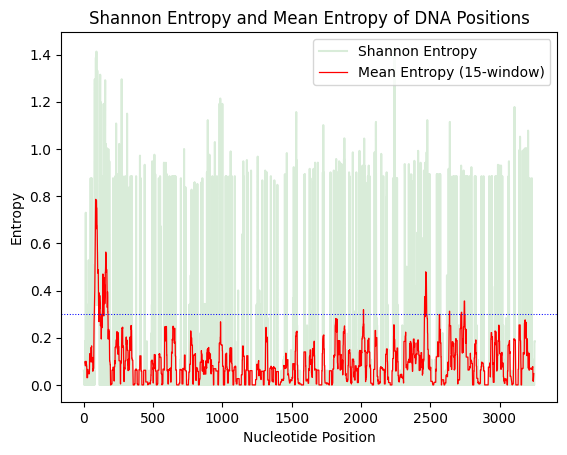

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import AlignIO
import pandas as pd

def shannon_entropy(column):
    # Remove stop codons
    column = [aa for aa in column if aa != "*"]
    
    # Calculate the frequency of each amino acid/nucleotide at each position
    counts = {}
    for aa in column:
        if aa in counts:
            counts[aa] += 1
        else:
            counts[aa] = 1
    
    # Calculate the Shannon entropy
    entropy = 0
    total_count = len(column)
    for count in counts.values():
        probability = count / total_count
        entropy -= probability * np.log2(probability)
    
    return entropy

def calculate_mean_entropy(entropy_values, window_size):
    mean_entropy = np.convolve(entropy_values, np.ones(window_size) / window_size, mode='valid')
    return mean_entropy

def main(input_file, window_size=15, threshold=0.3):
    try:
        # Read the alignment from the FASTA file
        alignment = AlignIO.read(input_file, "fasta")
    except FileNotFoundError:
        print(f"Error: File '{input_file}' not found.")
        return
    except ValueError:
        print(f"Error: Invalid format in file '{input_file}'.")
        return
    
    # Get the number of sequences and sequence length
    num_sequences = len(alignment)
    alignment_length = alignment.get_alignment_length()
    
    # Calculate Shannon entropy for each position
    entropy_values = []
    nucleotides = []
    positions = []
    for i in range(alignment_length):
        column = alignment[:, i]
        entropy = shannon_entropy(column)
        entropy_values.append(entropy)
        nucleotide = alignment[0, i]  # Assuming all sequences have same length
        nucleotides.append(nucleotide)
        positions.append(i + 1)
    
    # Calculate mean entropy over a sliding window
    mean_entropy = calculate_mean_entropy(entropy_values, window_size)
    
    # Plot the Shannon entropy values with thinner lines
    plt.plot(range(1, alignment_length + 1), entropy_values, marker='', linestyle='-', color='green', alpha=0.15, label='Shannon Entropy')
    
    # Plot mean entropy over the window
    plt.plot(range(window_size // 2 + 1, alignment_length - window_size // 2 + 1), mean_entropy, marker='', linestyle='-', color='red', alpha=1, linewidth=0.90, label=f'Mean Entropy ({window_size}-window)')
    
    # Add threshold dotted line
    plt.axhline(y=threshold, color='b', linestyle=':', linewidth=0.75)
    
    plt.xlabel('Nucleotide Position')
    plt.ylabel('Entropy')
    plt.title('Shannon Entropy and Mean Entropy of DNA Positions')
    plt.legend()
    
    # Save the plot as PDF
    plt.savefig("entropy_plot.pdf")
    
    # Show the plot
    plt.show()

    # Export top nucleotides with highest entropy to CSV
    top_indices = np.argsort(entropy_values)[-100:][::-1]
    top_nucleotides = [nucleotides[i] for i in top_indices]
    top_positions = [positions[i] for i in top_indices]
    top_entropies = [entropy_values[i] for i in top_indices]

    # Create DataFrame
    top_df = pd.DataFrame({
        "Entropy": top_entropies,
        "Nucleotide": top_nucleotides,
        "Position": top_positions
    })

    # Export DataFrame to CSV
    top_df.to_csv("top_nucleotides_with_highest_entropy.csv", index=False)

if __name__ == "__main__":
    input_file = "aligned_sequences.fasta"  
    main(input_file)


*Notebook Created By: Christian Mandelli, Oregon State University*